Оценим изменение метрик при внесении полиномиальных признаков.
Применим регуляризационные модели

# Импорт библиотек и данных

Launch a server via:
```bash
mlflow server --host 127.0.0.1 --port 8080
```

In [27]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor

root_folder = '../'
sys.path.append(root_folder)

from src.models import train_model, predict_model
from src.visualization import visualize
from src.utils import get_dict

train_path = Path(root_folder, 'data', 'processed', '2.0_train.csv')
test_path = Path(root_folder, 'data', 'processed', '2.0_test.csv')

experiment_name = 'Housing cost'

Загрузим датасеты:

In [2]:
train = pd.read_csv(train_path, index_col=0)
train.info()
X_train, y_train = train_model.get_X_y(train, target_name='log_target')
print()
print()

test = pd.read_csv(test_path, index_col=0)
test.info()
X_test, y_test = train_model.get_X_y(test, target_name='log_target')

<class 'pandas.core.frame.DataFrame'>
Index: 264639 entries, 0 to 264638
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            264639 non-null  float64
 1   fireplace                        264639 non-null  bool   
 2   beds                             264639 non-null  float64
 3   stories                          264639 non-null  float64
 4   private_pool                     264639 non-null  bool   
 5   parking_count                    264639 non-null  float64
 6   central_heating                  264639 non-null  bool   
 7   central_cooling                  264639 non-null  bool   
 8   log_target                       264639 non-null  float64
 9   log_sqft                         264639 non-null  float64
 10  log_lotsize                      264639 non-null  float64
 11  updated_years                    264639 non-null  float64
 12  school_

## Отбор лучших признаков

Впоследствии может пригодиться.
Пока не отсекаем признаки

In [3]:
selector = SelectKBest(f_regression, k=15)
selector.fit(X_train, y_train)

features_kbest = selector.get_feature_names_out()
display(features_kbest)

# X_train = X_train[features_kbest]
# X_train.info()

array(['baths', 'fireplace', 'beds', 'stories', 'private_pool',
       'parking_count', 'log_sqft', 'updated_years',
       'median_school_rating', 'status_foreclosure/pending', 'state_CA',
       'state_NY', 'state_OH', 'property_type_land/mobile',
       'parking_type_garage'], dtype=object)

## Pure RandomForestRegressor

RandomForestRegressor, как и другие модели на деревьях решений не требует масштабирования признаков. Также не будем создавать полиномиальные признаки.

Сначала идёт `SimpleImputer` на случай, если при использовании этой модели попадутся NaN-ы.
Сейчас пропусков нет.

В конце - модель RandomForestRegressor.

Изначально, проверка велась на 15 признаках, однако подстановка всех признаков улучшает итоговый результат

In [4]:
# selector_params = get_dict(
#     score_func=f_regression,
#     k=15,
# )

imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)

rf_params = get_dict(
    n_estimators=10,
    max_depth=12,
)

pipe_elements = [
    # ('selector', SelectKBest, selector_params),
    ('imputer', SimpleImputer, imputer_params),
    ('regressor', RandomForestRegressor, rf_params)
]

pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
cv_metrics = predict_model.cross_validate_pipe(
    pipe=pipe,
    X=X_train,
    y=y_train,
    njobs=3
)

pipe.fit(X_train, y_train)
metrics = predict_model.get_train_test_metrics(
    pipe,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
metrics = metrics | cv_metrics

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 RandomForestRegressor(max_depth=12, n_estimators=10))])

,cv_train,cv_validation
mape_log,0.030,0.032
r2_log,0.648,0.608


,train,test
mape,0.429,0.457
r2,0.597,0.529


In [6]:
model_info = predict_model.log_pipe_mlflow(
    pipe_name='random-forest-all',
    training_info='Random Forest with all features',
    X=X_train,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
    experiment_name=experiment_name,
)

Successfully registered model 'random-forest-all'.
2024/04/24 23:38:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random-forest-all, version 1
Created version '1' of model 'random-forest-all'.


<Axes: >

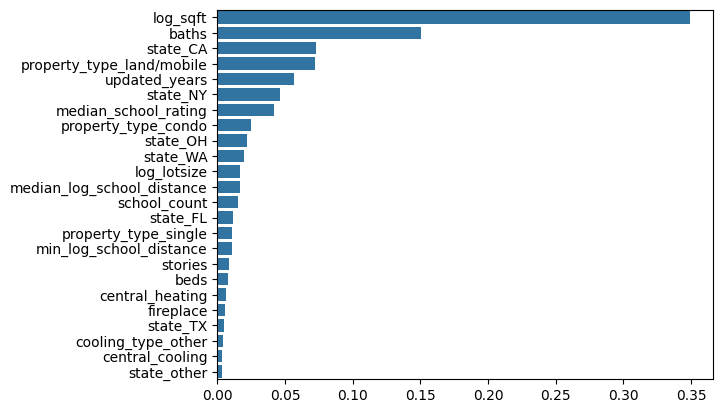

In [40]:
import seaborn as sns

sns.barplot(
    feature_importances[:15:-1],
    orient='h',
)

<Axes: >

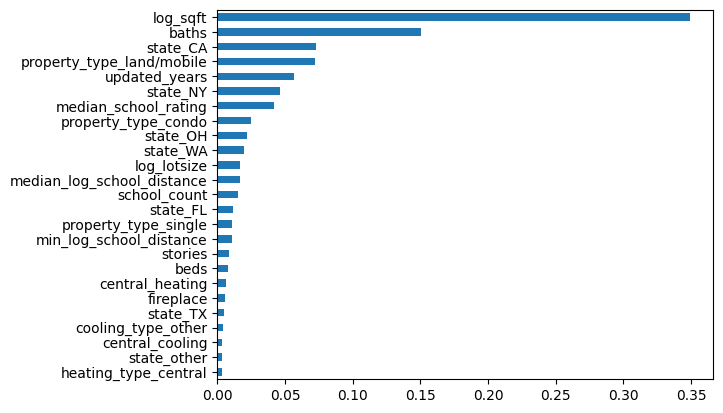

In [34]:
feature_importances = pd.Series(
    pipe[-1].feature_importances_, 
    index=pipe[-2].get_feature_names_out()
).sort_values()
feature_importances.iloc[-25:].plot.barh()

Удалось получить наименьший процент ошибки `MAPE`, чем в бейзлайнах и регуляризации: $45.7$% против 47.5% на Ridge.

$R^2 = 0.529$ лучше чем у дерева решений (0.492)